# Deep learning
---------------------------

This example shows how we can use ATOM to train and validate a Convolutional Neural Network implemented using [Keras](https://keras.io/).

Import the MNIST dataset from [keras.datasets](https://keras.io/api/datasets/mnist/). This is a well known image dataset with handwritten digits.

## Load the data

In [1]:
# Disable annoying tf warnings
import logging
import tensorflow as tf
tf.get_logger().setLevel(logging.ERROR)

# Import standard packages
from atom import ATOMClassifier, ATOMModel
from skopt.space.space import Integer, Categorical

# Keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D
from keras.wrappers.scikit_learn import KerasClassifier

In [2]:
# Create the convolutional neural network
def neural_network():
    model = Sequential()
    model.add(Conv2D(64, kernel_size=3, activation="relu", input_shape=(28, 28, 1)))
    model.add(Conv2D(64, kernel_size=3, activation="relu"))
    model.add(Flatten())
    model.add(Dense(10, activation="softmax"))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model


# Since ATOM uses sklearn's API, use Keras' wrapper
model = KerasClassifier(neural_network, epochs=1, batch_size=512, verbose=0)

# Convert the model to an ATOM model
model = ATOMModel(model, acronym='NN', fullname='Neural network')
model.type = 'deep'

In [3]:
# Download the MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [4]:
# Reshape data to fit model
X_train = X_train.reshape(60000,28,28,1)
X_test = X_test.reshape(10000,28,28,1)

## Run the pipeline

In [5]:
atom = ATOMClassifier((X_train, y_train), (X_test, y_test), n_rows=0.1, n_jobs=4, warnings=False, verbose=2)

<< ================== ATOM ================== >>
Algorithm task: multiclass classification.
Parallel processing with 4 cores.

Dataset stats ================== >>
Shape: (7000, 2)
Categorical columns: 1
Scaled: False
-----------------------------------
Train set size: 6000
Test set size: 1000
-----------------------------------
Train set balance: 0:1:2:3:4:5:6:7:8:9 <==> 1.1:1.3:1.1:1.2:1.2:1.0:1.1:1.2:1.1:1.2
Test set balance: 0:1:2:3:4:5:6:7:8:9 <==> 1.2:1.3:1.4:1.4:1.2:1.0:1.2:1.2:1.3:1.0
-----------------------------------
Distribution of classes:
|    |   dataset |   train |   test |
|---:|----------:|--------:|-------:|
|  0 |       700 |     599 |    101 |
|  1 |       798 |     690 |    108 |
|  2 |       671 |     557 |    114 |
|  3 |       728 |     614 |    114 |
|  4 |       700 |     605 |     95 |
|  5 |       604 |     522 |     82 |
|  6 |       694 |     594 |    100 |
|  7 |       731 |     630 |    101 |
|  8 |       685 |     582 |    103 |
|  9 |       689 |     6

In [6]:
# When the input data has more than 2 dimensions, ATOM creates a 
# dataset with just one column of shape (n_samples, shape_sample)
print(atom.dataset.head())
print(f"\nEvery row in the column contains the data of one image, with shape: {atom.dataset.iloc[0, 0].shape}")

                                            Features  target
0  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...       6
1  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...       6
2  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...       7
3  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...       3
4  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...       5

Every row in the column contains the data of one image, with shape: (28, 28, 1)


In [7]:
# Like any other model, we can define custom dimensions for the bayesian optimization
dim = [Integer(1, 3, name="epochs"), Categorical([32, 64, 128, 256], name="batch_size")]

atom.run(model, metric="f1_weighted", n_calls=5, bo_params={"dimensions": dim, "cv": 1, "max_time": 120})


Training ===================================== >>
Models: NN
Metric: f1_weighted


Running BO for Neural network...
Initial point 1 ---------------------------------
Parameters --> {'epochs': 1, 'batch_size': 256}
Evaluation --> f1_weighted: 0.8649  Best f1_weighted: 0.8649
Time iteration: 0.000s   Total time: 0.000s
Initial point 2 ---------------------------------
Parameters --> {'epochs': 2, 'batch_size': 64}
Evaluation --> f1_weighted: 0.9508  Best f1_weighted: 0.9508
Time iteration: 0.000s   Total time: 0.000s
Initial point 3 ---------------------------------
Parameters --> {'epochs': 2, 'batch_size': 64}
Evaluation --> f1_weighted: 0.9542  Best f1_weighted: 0.9542
Time iteration: 0.000s   Total time: 0.000s
Initial point 4 ---------------------------------
Parameters --> {'epochs': 3, 'batch_size': 128}
Evaluation --> f1_weighted: 0.9601  Best f1_weighted: 0.9601
Time iteration: 0.000s   Total time: 0.000s
Initial point 5 ---------------------------------
Parameters --> {'epochs

## Analyze the results

In [8]:
# We can use the prediction methods like any other model
atom.nn.predict_proba(X_train)

array([[5.0407805e-14, 2.2141787e-10, 3.3515974e-08, ..., 2.2435853e-09,
        9.2828380e-08, 8.2118101e-10],
       [9.9999964e-01, 3.9441506e-12, 9.9182053e-08, ..., 1.9030351e-10,
        3.4656900e-08, 7.1214111e-11],
       [7.2111336e-12, 9.3043303e-13, 4.1211483e-09, ..., 7.7885829e-07,
        2.3483340e-09, 4.5287823e-07],
       ...,
       [2.2917888e-14, 6.6365316e-11, 6.7521146e-13, ..., 1.2312615e-13,
        1.4910498e-08, 6.3661055e-08],
       [2.4478377e-06, 1.0323388e-09, 1.0190422e-08, ..., 2.6276856e-09,
        6.7731656e-09, 1.4052015e-12],
       [1.8761538e-03, 1.1924357e-07, 8.4914991e-06, ..., 1.2635953e-03,
        9.8836386e-01, 1.2008455e-03]], dtype=float32)

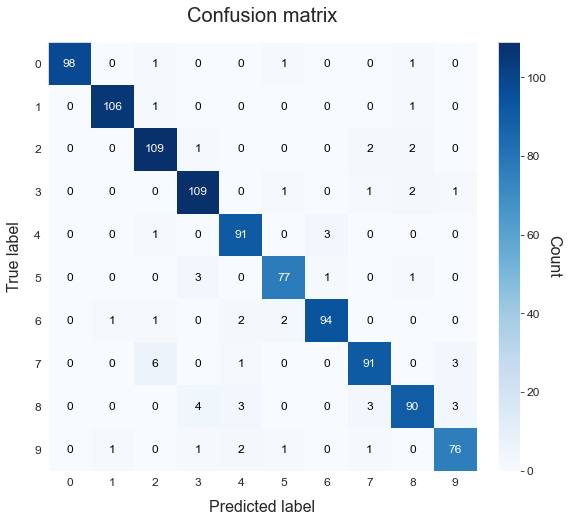

In [9]:
# Or make plots...
atom.nn.plot_confusion_matrix()